In [1]:
from specim.specfuncs import spec1d
from astropy.io import fits

import matplotlib.pyplot as plt
import numpy as np

### Load the observed feige110 spectra and mark the lines to mask.

In [2]:
obs_spec1 = spec1d.Spec1d('../other_spectra/spec1d_r201121_0027-Feige110_LRISr_2020Nov21T043747.165.fits',
                         informat='pypeit')
obs_spec2 = spec1d.Spec1d('../other_spectra/spec1d_r201121_0028-Feige110_LRISr_2020Nov21T044234.790.fits',
                          informat='pypeit')


Reading spectrum from ../other_spectra/spec1d_r201121_0027-Feige110_LRISr_2020Nov21T043747.165.fits
Expected file format: pypeit
 Spectrum Start:  5645.15
 Spectrum End:     8920.92
 Dispersion (1st pixel):   0.77
 Dispersion (average):      0.80


Reading spectrum from ../other_spectra/spec1d_r201121_0028-Feige110_LRISr_2020Nov21T044234.790.fits
Expected file format: pypeit
 Spectrum Start:  5645.15
 Spectrum End:     8920.92
 Dispersion (1st pixel):   0.77
 Dispersion (average):      0.80



In [3]:
obs_spec = obs_spec1.__add__(obs_spec2)

 Spectrum Start:  5645.15
 Spectrum End:     8920.92
 Dispersion (1st pixel):   0.77
 Dispersion (average):      0.80



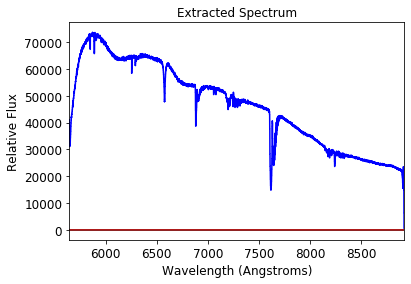

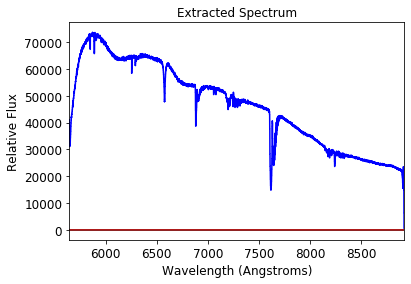

In [4]:
obs_spec.plot()

### Each element in the list contains crude wavelength range of the region to mask and the width in the blue and red side of the region to use for continum fitting.

In [5]:
linelist = [(5838.34, 5923.9, 100, 100), (6237.05, 6328.42, 100, 100), (6535.05, 6622.26, 100, 100),
            (6863.37, 6988.24, 150, 50), (7042.91, 7095.05, 50, 50), (7155.14, 7370.15, 100, 100),
            (7586.29, 7743.91, 100, 150), (8126.03, 8375.79, 100, 100), (8886.55, 8926.00, 150, 0)]

In [6]:

def closest_wavrange(spec_wav, wavrange=None, verbose=True):
    """
    This function extracts the closest wavelength range values 
    from the wavelength vector to a given crude wavelength range.
    """

    clst_wav_range = []
    wav_index = []

    if wavrange is None:
        print("\nneed to provide a list of wavelength ranges.")

    else:
        for i, p in enumerate(wavrange):

            wmin = abs(spec_wav - p[0])
            wmax = abs(spec_wav - p[1])

            """Converting the above arrays into list so that
               element value would be collectible given index"""

            wmin_list = wmin.tolist()
            wmax_list = wmax.tolist()

            start_index = wmin_list.index(min(wmin))
            stop_index = wmax_list.index(min(wmax))

            start_val = spec_wav[start_index]
            stop_val = spec_wav[stop_index]

            clst_wav_range.append((start_val, stop_val))
            wav_index.append((start_index, stop_index))

        """Print the given and closest waverange if requested """

        if verbose:
            print("\nGiven waverange(assumed) : \n")
            [print(*wvrange) for wvrange in wavrange]
            print("\nClosest waverange to the given ones : \n")
            [print(*wvrange) for wvrange in clst_wav_range]

    return  clst_wav_range, wav_index

In [7]:
def plot_maskline(spec_wav, spec_flux, wav_mask_line=None, color='y', title=None, 
                     label='masked reg', width=10.0):
        
    """
    A function to plot bars over the lines going to mask.
    """
    if wav_mask_line is None:
        print("\n Error: Need to provide wavelengths of the lines")

    else:
        if title is None:
            title = 'lines to mask'

        cen = np.zeros(len(wav_mask_line))
        wd = np.zeros(len(wav_mask_line))

        for i, p in enumerate(wav_mask_line):

            cen[i]= np.median(p)
            if np.diff(p) >= width:
                wd[i] = np.diff(p)
            else:
                wd[i] = width 

        plt.figure()
        plt.plot(spec_wav, spec_flux)
        plt.bar(cen, height=max(spec_flux), width=wd, color=color, 
                label=label)
        plt.xlabel('Wavelength')
        plt.ylabel('Relative Flux')
        plt.legend()
        plt.title(title)

### Show the selected lines to mask and do the masking. Then show the masked spectra.

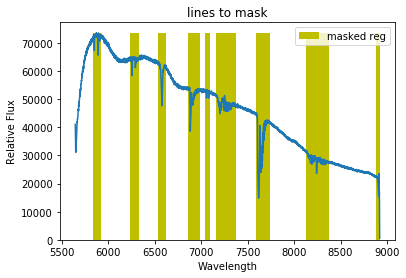

In [8]:
clst_wav_range, wav_index = closest_wavrange(obs_spec['wav'], wavrange=linelist, verbose=False)

plot_maskline(obs_spec['wav'], obs_spec['flux'], wav_mask_line=clst_wav_range)

bkgwidth = []

for i, p in enumerate(linelist):
    
    if len(p)==4:
        bkgwidth.append([p[2], p[3]])
    elif len(p)==3:
        bkgwidth.append(p[2])
    else:
        bkgwidth.append(100)
        
for i, (p, r) in enumerate(zip(clst_wav_range, bkgwidth)):
    
    linereg = np.array([p[0], p[1]])
    
    obs_spec.mask_line(linereg, r)
    #print(r)
    #print(linereg)    
#plt.figure()


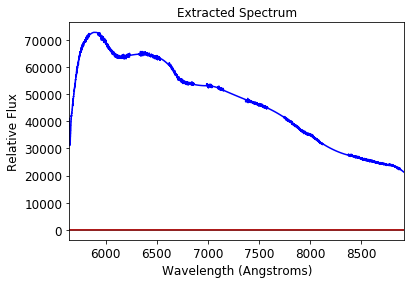

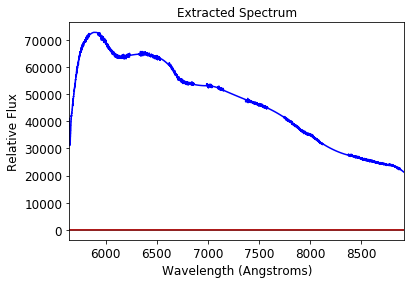

In [9]:
# observed spectra after replacing the selected lines with continum values 
obs_spec.plot()

### Now load the model spectra for feige110 and calculate the wavelength. Also select lines to mask if any. 

In [10]:
spec = fits.open('../other_spectra/feige110_ir_osp.fits')
hdr1 = spec[0].header

In [11]:
flux = spec[0].data[0]
wav = np.arange(flux.size)
wav = hdr1['CRVAL1'] + wav*hdr1['CDELT1']

In [12]:
mod_spec = spec1d.Spec1d(wav=wav, flux=flux)

 Spectrum Start:  3200.00
 Spectrum End:    11200.00
 Dispersion (1st pixel):   1.00
 Dispersion (average):      1.00



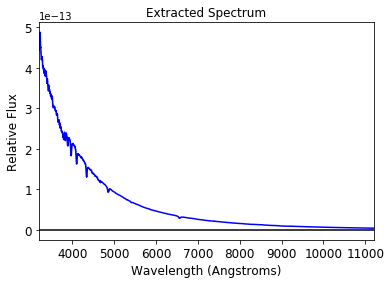

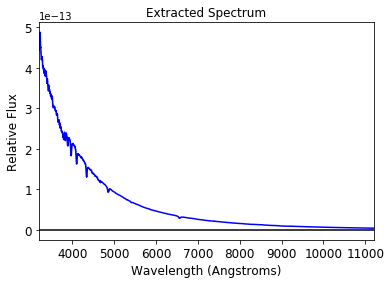

In [13]:
mod_spec.plot()

In [14]:
modlines = [(3767.46, 4131.49, 100, 100), (4306.29, 4390.99, 100, 100), (4812.93, 4904.51,100 ,100),
            (6524.47, 6619.27, 100, 100)]

### Also masking some lines in the model feige110 spectra.

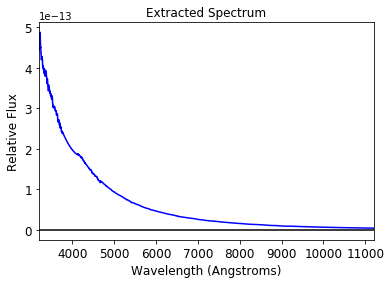

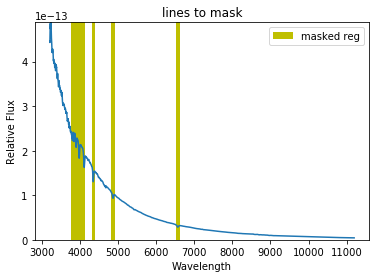

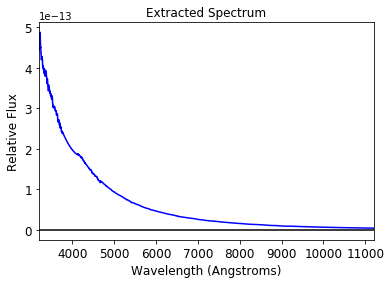

In [15]:
clst_wav_range, wav_index = closest_wavrange(mod_spec['wav'], wavrange=modlines, verbose=False)

plot_maskline(mod_spec['wav'], mod_spec['flux'], wav_mask_line=clst_wav_range)

bkgwidth = []

for i, p in enumerate(modlines):
    
    if len(p)==4:
        bkgwidth.append([p[2], p[3]])
    elif len(p)==3:
        bkgwidth.append(p[2])
    else:
        bkgwidth.append(100)
        
for i, (p, r) in enumerate(zip(clst_wav_range, bkgwidth)):
    
    linereg = np.array([p[0], p[1]])
    
    mod_spec.mask_line(linereg, r)
    #print(r)
    #print(linereg)    
#plt.figure()
mod_spec.plot()

### Now resampling the model spectra for the wave lengths of the observed feige110 spectra. After resampling the model spectra has the same wavelength range as the observed spectra.

In [16]:
mod_spec.resample(owave=obs_spec['wav'])

resample: replacing input spectrum with resampled version
resample: for now not resampling the variance


### As the numerical values of flux for the model spectra are very small, we normalize it with median value of the flux vector. We can see that doesn't change the shape of the resampled model spectra.

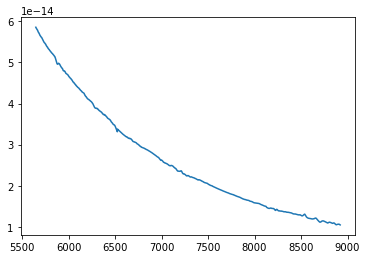

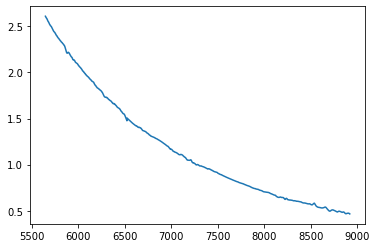

In [17]:
plt.figure()
plt.plot(mod_spec.rswav, mod_spec.rsflux)
plt.figure()
plt.plot(mod_spec.rswav, mod_spec.rsflux/np.median(mod_spec.rsflux))

### Going to calculate the response curve by dividing observed feige110 spectra with the model resampled feige110 spectra.

In [18]:
response = obs_spec['flux'] / (mod_spec.rsflux / np.median(mod_spec.rsflux))

Text(0.5, 1.0, 'response curve')

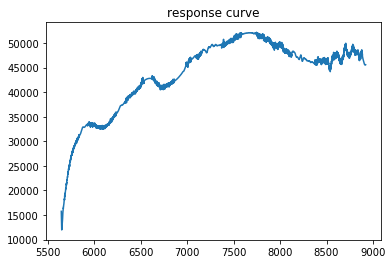

In [19]:
plt.figure()
plt.plot(obs_spec['wav'], response)
plt.title('response curve')

### Just a check. If we divide the observed spectra with the response curve we should get back the resampled model spectra.

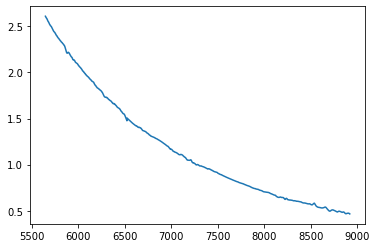

In [20]:
plt.figure()
plt.plot(obs_spec['wav'], obs_spec['flux'] /response)

### Not sure whether to divide or multiply the observed spectra with the response curve. Division will give the resampled model spectra as above. So multiplying the observed feige110 spectra with the response curve. Then plot the response corrected spectra.

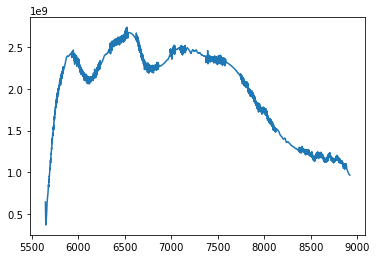

In [21]:
obs_spec.resp_corr(response)
plt.figure()
plt.plot(obs_spec['wav'], obs_spec['flux'])

### Now going to load a 1d galaxy spectra and apply response correction to that.

In [22]:
gal_spec = spec1d.Spec1d('../galaxy_spectra/lris-longslit-red-1120/j0040-coadd.fits', informat='pypeit')


Reading spectrum from ../galaxy_spectra/lris-longslit-red-1120/j0040-coadd.fits
Expected file format: pypeit
 Spectrum Start:  5648.49
 Spectrum End:     8924.46
 Dispersion (1st pixel):   0.77
 Dispersion (average):      0.80



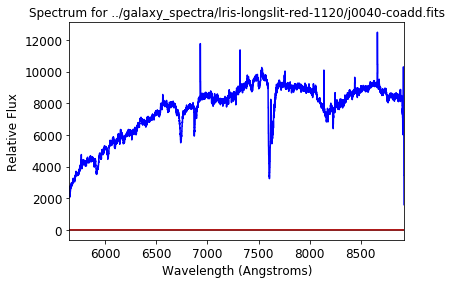

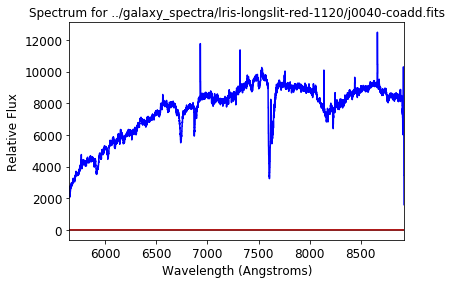

In [23]:
gal_spec.plot()

In [24]:
gal_spec.resp_corr(response, action='divide')

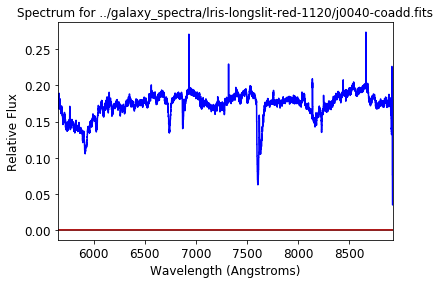

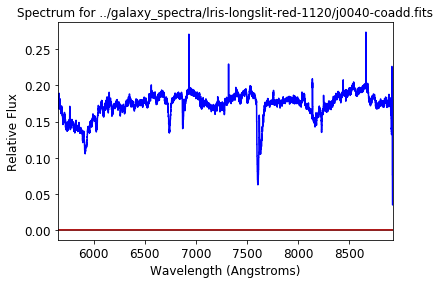

In [25]:
gal_spec.plot()

### Save the response curve as a 1d spectra.

In [26]:
response1d = spec1d.Spec1d(wav=obs_spec['wav'], flux=response)

 Spectrum Start:  5645.15
 Spectrum End:     8920.92
 Dispersion (1st pixel):   0.77
 Dispersion (average):      0.80



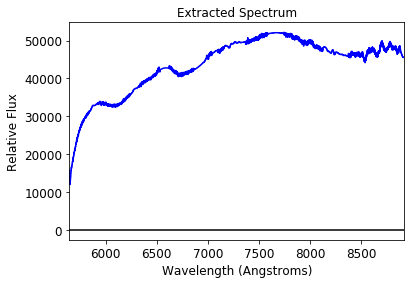

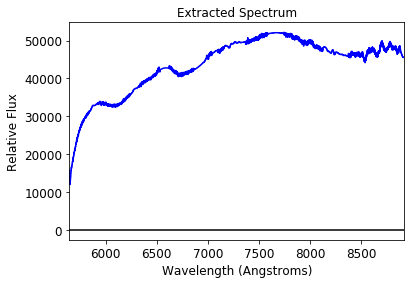

In [27]:
response1d.plot()

In [28]:
response1d.save('response_curve_from_feige110_r11202020.txt', outformat='text')


Saved spectrum to file response_curve_from_feige110_r11202020.txt in format text
